*Importing the libraries*

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
print(os.listdir("../input"))

['test.tif']


*Energy function to calculate energy of an image*

In [2]:
def calcEnergy(u_x, h_x):
    sobelx = cv2.Sobel(u_x,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(u_x,cv2.CV_64F,0,1,ksize=5)
    grad = cv2.add(sobelx, sobely)
    absolute_grad = np.abs(grad)
    # cv2.imshow('grad', absolute_grad)
    part1 = np.sum(absolute_grad)
    part2 = np.sum(np.multiply(h_x, u_x))
    lam = 2
    energy = part1 + lam * part2
    return energy

*Function to plot segmented regions*

In [3]:
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    plt.imshow(labeled_img)
    plt.show()

*Reading the image file*

In [4]:
test = cv2.imread('../input/test.tif',0)
img = test[0:144,0:303]

*Calculating the intensity fitting term*

In [5]:
zeros = np.zeros(np.shape(img))
wf = cv2.rectangle(zeros,(120, 40),(170, 80),(255,0,0),-1) # $
c1 = np.sum(np.multiply(img, wf))/np.sum(wf)
c2 = np.sum(np.multiply(img, 1-wf))/np.sum(1-wf)
f = (img-c1)**2 - (img-c2)**2

*Calculating the Heaviside function*

In [6]:
H = np.heaviside(-f, 0)
H = np.uint8(H)

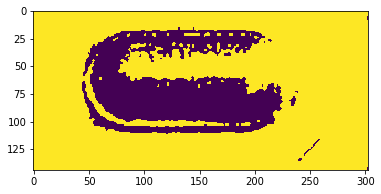

In [7]:
plt.imshow(H)
plt.show()

*Finding connected components *

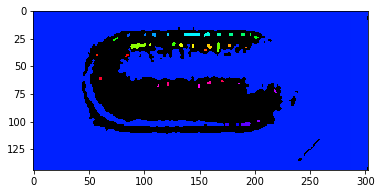

In [8]:
ret, labels = cv2.connectedComponents(H)
final_label = labels[102][82]
imshow_components(labels)

*Most likely foreground region*

In [9]:
w = np.zeros(np.shape(img))
for i in range(len(f)):
    for j in range(len(f[i])):
        if labels[i][j] == final_label and H[i][j] == 1:
            w[i][j] = 1
        else:
            w[i][j] = 0

*Supressing the fitting term to remove unwanted points*

In [10]:
hx = f * (1 - H + w)

*Scaling*

In [11]:
mh = max(hx.min(), hx.max(), key=abs)
h_x = hx/mh

*Calculating energy of an image*

In [12]:
u_x = np.zeros(np.shape(img))
u_x[h_x < 0] = 1
energy = calcEnergy(u_x, h_x)
print(energy)

174026.45027357576


*Labeling foreground region*

In [13]:
foreground = np.zeros(np.shape(img))
foreground[u_x > 0.5] = 1

*Highlighting the foreground region*

In [14]:
img[foreground == 1] = 255

*Plotting the segmented image*

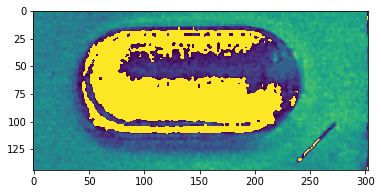

In [15]:
plt.imshow(img)
plt.show()